# Sources

http://cs.stanford.edu/people/jcjohns/eccv16/

https://github.com/lengstrom/fast-style-transfer

# Background

Style transfer is a a problem in which the goal is to modify the style of a "content image" to match that of a "style image".
The comparison of style transfer methods is much more subjective than other machine learning problems.
This is because the problem of style transfer is much more loosely defined.
This notebook will go over how to perform style transfer using pretrained models.
There are many other methods to perform style transfer using neural networks that are not covered in this notebook.

# Overview

The style transfer method used in this notebook follows the following step:

- We start with an image transformation network, composed of convolutional and deconvolutional layers.
- Using VGG19 pretrained on ImageNet, we can extract the features of images at different intermediate layers for the content and style images, and use these features to compute the loss.
- Training the image transform net for a particular style takes >6 hours on a Tesla P100, but evaluating (stylizing) takes less than a couple seconds, and can be done on most consumer hardware.

This can be seen in the diagram below - notice how the style is made up of multiple different layers and the features are taken from one or a few layers.

<img src="nb-files/arch.png"/>
Source: Perceptual losses for real-time style transfer and super-resolution - Johnson, Alahi, Li

<img src="nb-files/doge.jpg"/>
<img src="nb-files/wave.jpg" style="width: 500px;"/>
<img src="nb-files/doge-wave.jpg"/>

# VGG19

First we need to recreate VGG19 to take an input tensor with arbirarty size predecessors. In order to do this, we must manually load the weights for each layer, because Keras' load_weights() assumes the model will be the exact same shape as in the exported weights file.

In [3]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np
import tensorflow as tf

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([103.939, 116.779, 123.68])

weights_path = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        WEIGHTS_PATH_NO_TOP,
                        cache_subdir='models',
                        file_hash='253f8cb515780f3b799900260a226db6')
WEIGHTS_FILE = h5py.File(weights_path)

def vgg_layers(img_input, input_shape):
    # Block 1
    img_input = Input(tensor=img_input, shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x


def load_weights(model):
    f = WEIGHTS_FILE
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            g = f[b_name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False


def VGG19(img_input, input_shape):
    """
    VGG19, but can take input_tensor, and load weights on VGG layers only
    """
    model = Model(img_input, vgg_layers(img_input, input_shape), name='vgg19')
    load_weights(model)
    return model


def preprocess_input(x):
    # Convert 'RGB' -> 'BGR'
    if type(x) is np.ndarray:
        x = x[..., ::-1]
    else:
        x = tf.reverse(x, [-1])

    return x - MEAN_PIXEL

# Loss Function

The loss is composed of three distinct losses: the feature reconstruction loss, style reconstruction loss, and TV loss.

###### $\phi_j(x)$ is the activation of the $j$th layer in VGG19...

### Content loss

Content loss is defined as the squared, normalized Euclidean distance between the feature representations:

$$ \ell^{\phi, j}_{feat}(\hat{y}, y) = \frac{1}{C_jH_jW_J} \lVert \phi_j(\hat{y}) - \phi_j(y) \rVert^2_2 $$


### Style loss
Style loss is defined as the squared Frobenius norm of the difference between the Gram matrices of the output and target images:

$$ \ell^{\phi, j}_{style}(\hat{y}, y) = \lVert G^{\phi}_j(\hat{y}) - G^{\phi}_j(\hat{y}) \rVert^2_F $$

The Gram matrix can be computed efficiently by:

$$ G^{\phi}_j(x) = \psi\psi^T / C_jH_jW_j $$

where $\psi$ is $\phi_j(x)$ reshaped with shape $ C_j \times H_jW_j $.

With multiple style layers, we take the sum of losses for each layer.

### Total Variation Regularization

TV loss is a signal processing concept that is used to measure noise in an image.

The actual TV loss formula is not easily differentiable.
Therefore, in machine learning and minimization problems the following formula is used as minimizing this formula also greatly reduces TV loss.
<img src="./nb-files/tv_loss.svg">

The most important thing to understand about TV loss in this problem is that it represents noise in an image.

To read more on TV loss look at some of the citations referenced here:
https://en.wikipedia.org/wiki/Total_variation_denoising#2D_signal_images

# Implementation

Because Keras models expect a loss function with the signature f(y_true, y_pred) when calling model.compile(), we create a wrapper function to create this function as a closure, with the style image, weights and batch size.

In [4]:
from functools import reduce

from keras.models import Model, Sequential
from keras.layers import Input
from keras import backend as K
import numpy as np
import tensorflow as tf

from vgg import VGG19, preprocess_input

STYLE_LAYERS = ('block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1',
                'block5_conv1')

CONTENT_LAYERS = ('block4_conv2',)

CONTENT_TRAINING_SIZE = (256, 256, 3)

def tensor_size(x):
    return tf.to_float(K.prod(K.shape(x)))

def l2_loss(x):
    return K.sum(K.square(x)) / 2


def get_vgg_features(input, layers, input_shape):
    if len(K.int_shape(input)) == 3:
        input = K.expand_dims(input, axis=0)
    input = preprocess_input(input)
    vgg = VGG19(input, input_shape)
    outputs = [layer.output for layer in vgg.layers if layer.name in layers]
    return outputs


def calculate_content_loss(content_image, reconstructed_image,
                           content_weight, image_shape, batch_size):
    content_features = get_vgg_features(
            content_image, CONTENT_LAYERS, image_shape)[0]
    reconstructed_content_features = get_vgg_features(
            reconstructed_image, CONTENT_LAYERS, image_shape)[0]

    content_size = tensor_size(content_features) * batch_size
    content_loss = content_weight * (2 * l2_loss(
        reconstructed_content_features - content_features) / content_size)

    return content_loss


def calculate_style_features_grams(features, batch_size):
    grams = []
    for feats in features:
        _, h, w, filters = K.int_shape(feats)

        # shape in K.reshape needs to be np.array to convert Dimension to int
        # (should be fixed in newer versions of Tensorflow)
        feats = K.reshape(feats, np.array((batch_size, h * w, filters)))

        feats_size = h * w * filters
        feats_T = tf.transpose(feats, perm=[0,2,1])
        gram = tf.matmul(feats_T, feats) / feats_size
        grams.append(gram)
    return grams


def calculate_style_loss(style_grams, reconstructed_image,
                         style_weight, style_image_shape, content_image_shape,
                         batch_size):
    # Get outputs of style and content images at VGG layers
    reconstructed_style_vgg_features = get_vgg_features(
            reconstructed_image, STYLE_LAYERS, content_image_shape)

    # Calculate the style features of the style image and output image
    # Style features are the gram matrices of the VGG feature maps
    style_rec_grams = calculate_style_features_grams(
            reconstructed_style_vgg_features, batch_size)

    # Calculate style loss
    style_losses = []
    for style_gram, style_rec_gram in zip(style_grams, style_rec_grams):
        style_gram_size = tensor_size(style_gram)
        l2 = l2_loss(style_rec_gram - style_gram)
        style_losses.append(2 * l2 / style_gram_size)

    style_loss = style_weight * reduce(tf.add, style_losses) / batch_size

    return style_loss


def calculate_tv_loss(x, tv_weight, batch_size):
    tv_y_size = tensor_size(x[:,1:,:,:])
    tv_x_size = tensor_size(x[:,:,1:,:])
    y_tv = l2_loss(x[:,1:,:,:] - x[:,:CONTENT_TRAINING_SIZE[0]-1,:,:])
    x_tv = l2_loss(x[:,:,1:,:] - x[:,:,:CONTENT_TRAINING_SIZE[1]-1,:])
    tv_loss = tv_weight*2*(x_tv/tv_x_size + y_tv/tv_y_size)/batch_size
    return tv_loss


def create_loss_fn(style_image, content_weight,
                   style_weight, tv_weight, batch_size):
    style_image = tf.convert_to_tensor(style_image)

    # Precompute style features and grams
    style_vgg_features = get_vgg_features(
            style_image, STYLE_LAYERS, K.int_shape(style_image))
    style_grams = calculate_style_features_grams(style_vgg_features, 1)

    def style_transfer_loss(y_true, y_pred):
        """
        y_true - content_image
        y_pred - reconstructed image
        """

        content_image = y_true
        reconstructed_image = y_pred

        content_loss = calculate_content_loss(content_image,
                                              reconstructed_image,
                                              content_weight,
                                              CONTENT_TRAINING_SIZE,
                                              batch_size)
        style_loss = calculate_style_loss(style_grams,
                                          reconstructed_image,
                                          style_weight,
                                          K.int_shape(style_image),
                                          CONTENT_TRAINING_SIZE,
                                          batch_size)
        tv_loss = calculate_tv_loss(reconstructed_image, tv_weight, batch_size)

        loss = content_loss + style_loss + tv_loss
        return loss

    return style_transfer_loss

# Transform

The transformation network is the model that will be trained. It takes an image as input, and outputs a transformed image. It is composed of convolutional layers with ReLU and instance normalization, residual blocks, and then deconvolutional layers, ending with a tanh activation function, which is scaled back to RGB pixel rangles (0-255).

In [5]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Lambda, Activation
from keras.models import Model
import keras.layers
from keras.initializers import TruncatedNormal

from keras_contrib.layers.normalization import InstanceNormalization

WEIGHTS_INIT_STDEV = .1

def Conv2DInstanceNorm(inputs, filters, kernel_size,
                           strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2D(filters,
                  (kernel_size, kernel_size),
                  strides=strides,
                  padding='same',
                  kernel_initializer=weights_init,
                  use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DTransposeInstanceNorm(inputs, filters, kernel_size,
                                strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2DTranspose(filters,
                           (kernel_size, kernel_size),
                           strides=strides,
                           padding='same',
                           kernel_initializer=weights_init,
                           use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DResidualBlock(inputs):
    tmp     = Conv2DInstanceNorm(inputs, 128, 3)
    tmp2    = Conv2DInstanceNorm(tmp, 128, 3, relu=False)
    return keras.layers.add([inputs, tmp2])

def TransformNet(inputs):
    conv1   = Conv2DInstanceNorm(inputs, 32, 9)
    conv2   = Conv2DInstanceNorm(conv1, 64, 3, strides=2)
    conv3   = Conv2DInstanceNorm(conv2, 128, 3, strides=2)
    resid1  = Conv2DResidualBlock(conv3)
    resid2  = Conv2DResidualBlock(resid1)
    resid3  = Conv2DResidualBlock(resid2)
    resid4  = Conv2DResidualBlock(resid3)
    resid5  = Conv2DResidualBlock(resid4)
    conv_t1 = Conv2DTransposeInstanceNorm(resid5, 64, 3, strides=2)
    conv_t2 = Conv2DTransposeInstanceNorm(conv_t1, 32, 3, strides=2)
    conv_t3 = Conv2DInstanceNorm(conv_t2, 3, 9, relu=False)
    tanh = Activation('tanh')(conv_t3)
    preds = Lambda(lambda x : x * 150 + 255./2)(tanh)
    return preds

# Training

When calling fit on our model, we pass content images where X = y. Using Keras' ImageDataGenerator, we can create a generator to load images straight from a directory.

We use the MSCOCO image set, which consists of ~80K images. A single epoch with batch size of 4 takes approximately 3 hours on a Nvidia Tesla P100. We normally train for at least 2-8 epochs to eliminate artifacts.

### Progress (takes a second to load)
<video controls src="nb-files/progress.mp4" />

In [ ]:
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from keras.layers import Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from scipy.misc import imresize, imsave
import numpy as np
import pandas as pd
import tensorflow as tf

from transform import TransformNet
from loss import create_loss_fn


def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            # (X, y)
            # X will go through TransformNet,
            # y will go through VGG
            yield (img/255., img)

    return tuple_gen()


# Needed so that certain layers function in training mode
K.set_learning_phase(1)

style_img = image.load_img(options.style)
style_target = image.img_to_array(style_img)

inputs = Input(shape=(256, 256, 3))
transform_net = TransformNet(inputs)
model = Model(inputs=inputs, outputs=transform_net)
loss_fn = create_loss_fn(style_target, options.content_weight,
                         options.style_weight, options.tv_weight,
                         options.batch_size)
model.compile(optimizer='adam', loss=loss_fn)

gen = create_gen(options.train_path, target_size=(256, 256),
                 batch_size=options.batch_size)
model.fit_generator(gen, steps_per_epoch=options.steps_per_epoch,
                    epochs=options.epochs)
model.save(options.model_output)

# Evaluation

Stylizing an image is as simple as loading the trained model, and calling predict with the input image.

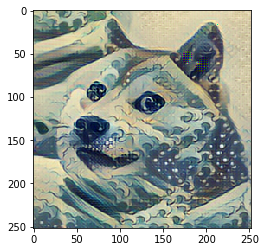

In [18]:
%matplotlib inline

from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from transform import TransformNet

BORDER_SIZE = 30

# Reflection padding to remove border effects
def pad(img, border_size):
    return np.pad(img, ((border_size, border_size),
                        (border_size, border_size),
                        (0,0)), mode='reflect')

def unpad(img, border_size):
    return img[border_size: -border_size, border_size: -border_size]


# Get input image
input_img = image.load_img('nb-files/doge.jpg')
input_img = image.img_to_array(input_img)
input_img = pad(input_img, BORDER_SIZE)
input_img = np.expand_dims(input_img, axis=0)


# Load model
_, h, w, c = input_img.shape
inputs = Input(shape=(h, w, c))
transform_net = TransformNet(inputs)
model = Model(inputs, transform_net)
model.load_weights('nb-files/wave.h5')

output_img = model.predict([input_img])[0]
output_img = unpad(output_img, BORDER_SIZE)
plt.imshow(np.clip(output_img/255, 0, 255))

# Other Methods
There are tons of other awesome methods for style transfer.
If this strikes your interest look at some of there:
- a
- a
- a
- a
- a
- a